In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\kusha\anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
len(df['id'])

159571

In [5]:
df['Not toxic'] = 1 - df['toxic']

In [6]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Not toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


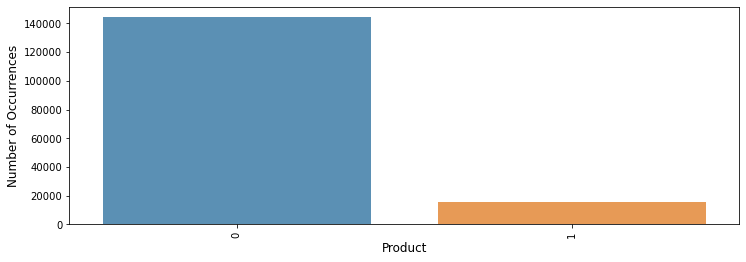

In [7]:
cnt_pro = df['toxic'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [8]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['comment_text'] = df['comment_text'].apply(cleanText)

C:\Users\kusha\anaconda3\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://en.wikipedia.org/wiki/Wikipedia_talk:No_original_research/archive15#YouTube_art_as_primary_source" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\kusha\anaconda3\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://finance.yahoo.com/news/7-fascinating-nuggets-another-bewildering-150348488.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\kusha\anaconda3\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://en.wikipedia.org/wiki/Wikipedia:ELYES" looks like a URL. Beautiful Soup is not an HTTP client. You shou

In [9]:
train, test = train_test_split(df, test_size=0.3, random_state=42)
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['comment_text']), tags=[r.toxic]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['comment_text']), tags=[r.toxic]), axis=1)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kusha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [11]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|█████████████████████████████████████████████████████████████████████| 111699/111699 [00:00<00:00, 3577807.36it/s]


In [12]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|█████████████████████████████████████████████████████████████████████| 111699/111699 [00:00<00:00, 3489442.75it/s]


Wall time: 5min 43s


In [18]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    #targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=20)) for doc in sents])
    return targets, regressors

In [19]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.9044117647058824
Testing F1 score: 0.859506001366529


C:\Users\kusha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|█████████████████████████████████████████████████████████████████████| 111699/111699 [00:00<00:00, 2330971.16it/s]


In [21]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|█████████████████████████████████████████████████████████████████████| 111699/111699 [00:00<00:00, 2327855.60it/s]


Wall time: 6min 54s


In [22]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.9015290775401069
Testing F1 score: 0.8786431401850192


C:\Users\kusha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

AttributeError: 'Doc2Vec' object has no attribute 'delete_temporary_training_data'

In [24]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

ModuleNotFoundError: No module named 'testfixtures'

In [ ]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, regressors

In [ ]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))